In [7]:
import numpy as np
import pandas as pd
import torch

from src import utils, models, metrics

In [18]:
df_movies, df_users, df_ratings = utils.read_pickles("../../data/ml-1m-after_eda/")

### Baseline predictor

In [38]:
train, test = utils.TrainTestSplitter.split_by_percent(df_ratings, 0.8,
                                                       sort_by_datetime=True)
true_ratings = test["Rating"].values
true_ratings

array([4, 4, 5, ..., 4, 3, 4])

In [21]:
base_model = models.BaseModelAverage()
base_model.fit(train)
predicted_scores_baseline = base_model.predict(test["MovieID"])

In [33]:
predicted_scores_baseline

array([3.58507223, 3.75510204, 4.17142857, ..., 3.10513447, 3.25333333,
       2.68571429])

### DeepLearning predictor

In [74]:
df = utils.dl_data_pipeline(df_movies, df_users, df_ratings)
df = df.drop(["UserID", "MovieID"], axis=1)
df.head(3)

,Rating,AvgUserRating,AvgMovieRating,Gender_F,Gender_M,Age_1,Age_18,Age_25,Age_35,Age_45,...,Decade_1910,Decade_1920,Decade_1930,Decade_1940,Decade_1950,Decade_1960,Decade_1970,Decade_1980,Decade_1990,Decade_2000
0,4,NaN,NaN,0,1,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
1,4,4.0,NaN,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
2,5,4.0,NaN,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


In [75]:
train, test = utils.TrainTestSplitter.split_by_percent(df, 0.8)

In [76]:
mean_users_rating = train["AvgUserRating"].mean()
mean_movies_rating = train["AvgMovieRating"].mean()

train["AvgUserRating"] = train["AvgUserRating"].fillna(mean_users_rating)
train["AvgMovieRating"] = train["AvgMovieRating"].fillna(mean_movies_rating)

test["AvgUserRating"] = test["AvgUserRating"].fillna(mean_users_rating)
test["AvgMovieRating"] = test["AvgMovieRating"].fillna(mean_movies_rating)

In [77]:
model = models.MovieRatingNN(112)
model.load_state_dict(torch.load("../../artifacts/simple_nn.pth"))
model.eval()

MovieRatingNN(
  (layer1): Linear(in_features=112, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=64, bias=True)
  (output_reg): Linear(in_features=64, out_features=1, bias=True)
)

In [78]:
test_tensor = torch.tensor(test.drop(["Rating"], axis=1).values,
                           dtype=torch.float32)
predicted_scores_nn = model.forward(test_tensor).detach().numpy().flatten()

### A/B Tester

In [79]:
from scipy import stats

class IncrementalABTester:
    def __init__(self):
        self.true_ratings = np.array([])
        self.predictions_baseline = np.array([])
        self.predictions_nn = np.array([])

    def add_data(self, true_rating, prediction_baseline, prediction_nn):
        self.true_ratings = np.append(self.true_ratings, true_rating)
        self.predictions_baseline = np.append(self.predictions_baseline, prediction_baseline)
        self.predictions_nn = np.append(self.predictions_nn, prediction_nn)

    def rmse(self, predictions):
        return np.sqrt(np.mean((self.true_ratings - predictions) ** 2))

    def run_tests(self):
        rmse_baseline = self.rmse(self.predictions_baseline)
        rmse_nn = self.rmse(self.predictions_nn)
        
        # Conduct a paired t-test if we have enough data
        if len(self.true_ratings) > 1:
            _, p_value = stats.ttest_rel(self.predictions_baseline, self.predictions_nn)
        else:
            p_value = np.nan  # Not enough data to test
        
        results = {
            'rmse_baseline': rmse_baseline,
            'rmse_nn': rmse_nn,
            'p_value': p_value
        }
        
        return results

In [80]:
tester = IncrementalABTester()

for true, baseline, nn in zip(true_ratings, predicted_scores_baseline,
                              predicted_scores_nn):
    tester.add_data(true, baseline, nn)
    if len(tester.true_ratings) % 20000 == 0:  # Periodic testing, e.g., every 5 records
        results = tester.run_tests()
        print(f"After {len(tester.true_ratings)} records: ", results)

After 20000 records:  {'rmse_baseline': 0.9698346482311361, 'rmse_nn': 0.9254584371866704, 'p_value': 0.0}
After 40000 records:  {'rmse_baseline': 0.9734893374751389, 'rmse_nn': 0.9389369210299985, 'p_value': 0.0}
After 60000 records:  {'rmse_baseline': 0.972793583637622, 'rmse_nn': 0.9382951779884745, 'p_value': 0.0}
After 80000 records:  {'rmse_baseline': 0.9739648946897694, 'rmse_nn': 0.9369347013156845, 'p_value': 0.0}
After 100000 records:  {'rmse_baseline': 0.9830537119479884, 'rmse_nn': 0.9373680171427647, 'p_value': 0.0}
After 120000 records:  {'rmse_baseline': 0.9767075100658202, 'rmse_nn': 0.934343118054592, 'p_value': 0.0}
After 140000 records:  {'rmse_baseline': 0.9706905793988605, 'rmse_nn': 0.9299150845867491, 'p_value': 0.0}
After 160000 records:  {'rmse_baseline': 0.9690716596690375, 'rmse_nn': 0.9280923062889181, 'p_value': 0.0}
After 180000 records:  {'rmse_baseline': 0.9680760821842996, 'rmse_nn': 0.928584281646724, 'p_value': 0.0}
After 200000 records:  {'rmse_basel

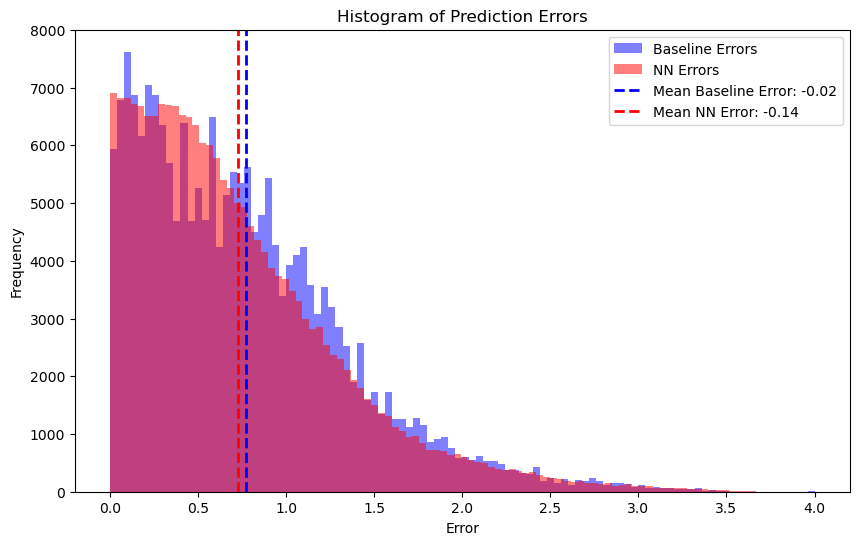

In [94]:
import matplotlib.pyplot as plt

# Calculate errors
errors_baseline = abs(true_ratings - predicted_scores_baseline)
errors_nn = abs(true_ratings - predicted_scores_nn)

# Calculate mean errors
mean_abs_error_baseline = np.mean(errors_baseline)
mean_abs_error_nn = np.mean(errors_nn)

# Plotting histograms
plt.figure(figsize=(10, 6))
plt.hist(errors_baseline, bins=100, alpha=0.5, label='Baseline Errors', color='blue')
plt.hist(errors_nn, bins=100, alpha=0.5, label='NN Errors', color='red')

# Adding mean lines
plt.axvline(mean_abs_error_baseline, color='blue', linestyle='dashed', linewidth=2, label=f'Mean Baseline Error: {mean_error_baseline:.2f}')
plt.axvline(mean_abs_error_nn, color='red', linestyle='dashed', linewidth=2, label=f'Mean NN Error: {mean_error_nn:.2f}')

# Adding labels and legend
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Errors')
plt.legend()

plt.show()